# Complete Imports and Wrangle Data

In [300]:
# Import of packages and package classes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [691]:
# Write a wrangle function for our dataset

def wrangle(filepath):
    # Establish path to data files
    DATA_PATH = '../data/class-project/LoanApproval/'
    
    # Read in the data
    df = pd.read_csv(DATA_PATH + filepath)
    print(df.shape)
    
    # Drop 'Loan_ID' column, it is an identifier only and will not affect model
    # No other high-cardinality colums 
    df.drop(columns='Loan_ID', inplace=True)
    
    # Clean data col names
    df.columns = [col.lower() for col in df.columns]
        
    df = df.rename(columns=
        {'applicantincome': 'applicant_income',
         'coapplicantincome': 'coapplicant_income',
         'loanamount': 'loan_amount'})
        
    # Convert 'credit_history' to binary categorical from float (ready for OHE/ordinal encoding)
    df['credit_history'].replace(to_replace={1.0: '1', 0.0: '0'}, 
                                 inplace=True)
       
    # Remove the outliers where income is > $250,000, and the two outliers where income is < $10,000
    df = df[ (df['applicant_income'] > 1_000) & 
             (df['applicant_income'] < 25_000)]
    
    # Remove the outlier for 'loan_amount' 
    df = df[df['loan_amount'] > 10]  
    
    # Convert 'coapplicant_income' and'loan_amount' to integers from floats
    for col in ['coapplicant_income', 'loan_amount']:
       df[col] = df[col].astype(int)
    
    # Address NaN values and prepare for OHE/Ordinal Encoding
    mode_cols = ['gender', 'married', 'dependents', 'self_employed', 'loan_amount_term', 'credit_history']
    for col in mode_cols:
        df[col].fillna(value=df[col].mode()[0], inplace=True)

#    df['gender'].fillna(value=df['gender'].mode()[0], inplace=True)
    
#     df['loan_amount_term'].fillna(value=df['loan_amount_term'].mode()[0], inplace=True)
    df['loan_amount_term'] = df['loan_amount_term'].astype(str)
    
#     df['credit_history'].fillna(value=df['credit_history'].mode()[0], inplace=True)
#     df['credit_history'] = df['credit_history']
    
#     df['dependents'].fillna(value=df['dependents'].mode()[0], inplace=True)
    df['dependents'] = df['dependents'].str.strip('+')

    # Convert target, 'LoanStatus' to binary numeric values
    df['loan_status'].replace(to_replace={'Y': 1, 'N':0}, inplace=True) 
    
    return df

train_path = 'train_data.csv'
train = wrangle(train_path)

(614, 13)


In [692]:
print(train.shape)
train.head()

(578, 12)


,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
1,Male,Yes,1,Graduate,No,4583,1508,128,360.0,1,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0,66,360.0,1,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358,120,360.0,1,Urban,1
4,Male,No,0,Graduate,No,6000,0,141,360.0,1,Urban,1
5,Male,Yes,2,Graduate,Yes,5417,4196,267,360.0,1,Urban,1


In [693]:
# Remaining NaN values are in categorical features and will be filled using an imputer with strategy='most_frequent'

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 578 entries, 1 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gender              578 non-null    object
 1   married             578 non-null    object
 2   dependents          578 non-null    object
 3   education           578 non-null    object
 4   self_employed       578 non-null    object
 5   applicant_income    578 non-null    int64 
 6   coapplicant_income  578 non-null    int64 
 7   loan_amount         578 non-null    int64 
 8   loan_amount_term    578 non-null    object
 9   credit_history      578 non-null    object
 10  property_area       578 non-null    object
 11  loan_status         578 non-null    int64 
dtypes: int64(4), object(8)
memory usage: 58.7+ KB


In [630]:
train['credit_history'].value_counts()

1    495
0     83
Name: credit_history, dtype: int64

In [690]:
train['dependents'].value_counts()

0    341
2     97
1     95
3     45
Name: dependents, dtype: int64

In [631]:
# EDA

print(train.shape)
train.head()

# 'gender', 'married', 'education', 'self_employed' are binary categorial variables
# 'loan_status' is our target feature
# 'credit_history' is indicated to mean 'credit history meets guidelines, Y/N', and should be an integer

(578, 12)


,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
1,Male,Yes,1,Graduate,No,4583,1508,128,360.0,1,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0,66,360.0,1,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358,120,360.0,1,Urban,1
4,Male,No,0,Graduate,No,6000,0,141,360.0,1,Urban,1
5,Male,Yes,2,Graduate,Yes,5417,4196,267,360.0,1,Urban,1


In [632]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 578 entries, 1 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gender              567 non-null    object
 1   married             576 non-null    object
 2   dependents          578 non-null    object
 3   education           578 non-null    object
 4   self_employed       550 non-null    object
 5   applicant_income    578 non-null    int64 
 6   coapplicant_income  578 non-null    int64 
 7   loan_amount         578 non-null    int64 
 8   loan_amount_term    578 non-null    object
 9   credit_history      578 non-null    object
 10  property_area       578 non-null    object
 11  loan_status         578 non-null    int64 
dtypes: int64(4), object(8)
memory usage: 58.7+ KB


In [633]:
# Categorical variables are not high cardinality

train.describe(exclude='number')

,gender,married,dependents,education,self_employed,loan_amount_term,credit_history,property_area
count,567,576,578,578,550,578,578,578
unique,2,2,4,2,2,10,2,3
top,Male,Yes,0,Graduate,No,360.0,1,Semiurban
freq,462,374,341,452,474,498,495,223


Male      0.814815
Female    0.185185
Name: gender, dtype: float64


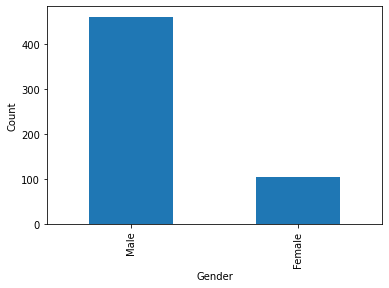

In [634]:
# Many more male applicants than female

print(train['gender'].value_counts(normalize=True))

train['gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show();

0    0.589965
2    0.167820
1    0.164360
3    0.077855
Name: dependents, dtype: float64


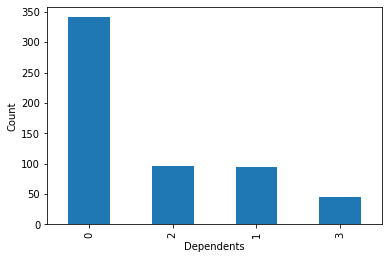

In [635]:
# Primary number of dependents is 0, 3+ are the most infrequent

print(train['dependents'].value_counts(normalize=True))

train['dependents'].value_counts().plot(kind='bar')
plt.xlabel('Dependents')
plt.ylabel('Count')
plt.show();

Graduate        0.782007
Not Graduate    0.217993
Name: education, dtype: float64 



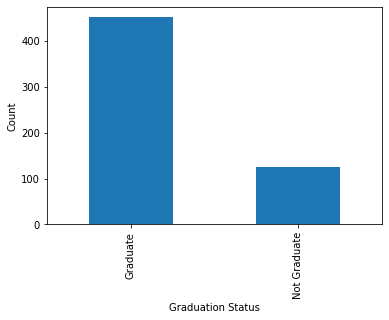

In [636]:
# More applicants are classified as 'Graduate' vs 'Not Graduate'

print(train['education'].value_counts(normalize=True), "\n")

train['education'].value_counts().plot(kind='bar')
plt.xlabel('Graduation Status')
plt.ylabel('Count')
plt.show();

No     0.861818
Yes    0.138182
Name: self_employed, dtype: float64 



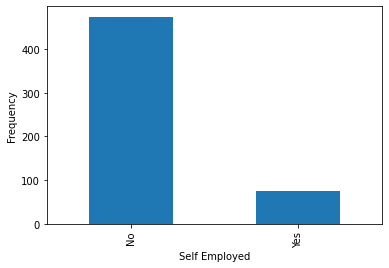

In [637]:
# More applicants work for someone else versus being self-employed

print(train['self_employed'].value_counts(normalize=True), "\n")

train['self_employed'].value_counts().plot(kind='bar')
plt.xlabel('Self Employed')
plt.ylabel('Frequency')
plt.show()

1025
[ 4583  3000  2583  6000  5417  2333  3036  4006 12841  3200  2500  3073
  1853  1299  4950  3596  3510  4887  2600  7660  5955  3365  3717  9560
  2799  4226  1442  3750  4166  3167  4692  3500 12500  1828  3667  3748
  3600  1800  2400  3941  4695  3410  5649  5821  2645  4000  1928  3086
  4230  4616 11500  2708  2132  3366  8080  3357  3029  2609  5726 10750
  7100  4300  3208  1875  4755  5266  3333  3846  1378  3988  2366  8566
  5695  2958  6250  3273  4133  3620  2484  1977  4188  1759  4288  4843
  3816  3052 11417  7333  3800  2071  5316  2929  3572  5050 14583  2214
  5568 10408  5667  2137  2957  3692 23803 10513  6080 20166  2014  2718
  3459  4895  3316 14999  4200  5042  6950  2698 11757  2330 14866  1538
 10000  4860  6277  2577  9166  2281  3254  9538  2980  1863  7933  3089
  4167  9323  3707  2439  2237  8000  1820  3522  5708  4344  3497  2045
  5516  6400  1916  4600  3625  2178  2383  9328  4885 12000  6033  3858
  4191  3125  8333  1907  3416 11000  4923  39

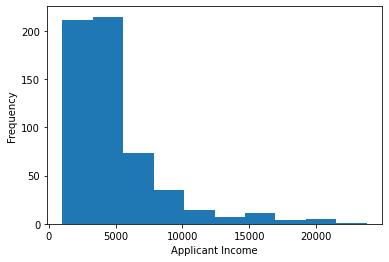

In [638]:
# After removing outliers, can see that most applicant income are in the 30,000 to 50,000 range, skewed to the right

print(train['applicant_income'].min())
print(train['applicant_income'].unique())

train['applicant_income'].plot(kind='hist')

plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show();

0
[ 1508     0  2358  4196  1516  2504  1526 10968   700  1840  8106  2840
  1086  3500  5625  1911  1917  2925  2253  1040  2083  3369  1667  3000
  1330  1459  7210  1668  1213  2336  3440  2275  1644  1167  1591  2200
  2250  2859  3796  3449  4595  2254  3066  1875  1774  4750  4000  2166
  1881  2531  2000  2118  4167  2900  5654  1820  2302   997  3541  3263
  3806   754  1030  1126  3600  2333  4114  2283  1398  2142  2667  8980
  2014  3850  2569  1929  7750  1430  2034  4486  1425  1666   830  3750
  1041  1280  1447  3166  3333  1769   736  1964  1619 11300  1451  7250
  5063  2138  2583  2365  2816  2500  1083  1250  3021   983  1775  2383
  1717  2791  1010  1695  2054  2598  1779  1260  5000  1983  5701  1300
  4417  4333  1843  1868  3890  2167  7101  2100  4250  2209  3447  1387
  1811  1560  1857  2223  1842  3274  2426   800   985  3053  2416  3334
  2541  2934  1750  1803  1863  2405  1640  2134   189  2985  4983  2160
  2451  1793  1833  4490   688  4600  1587  1229 

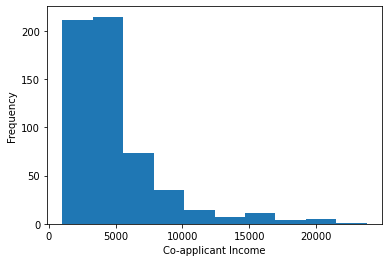

In [639]:
# Distribution of 'coapplicant_income'

print(train['coapplicant_income'].min())
print(train['coapplicant_income'].unique())

train['applicant_income'].plot(kind='hist')

plt.xlabel('Co-applicant Income')
plt.ylabel('Frequency')
plt.show();

17
[128  66 120 141 267  95 158 168 349  70 109 200 114  17 125 100  76 133
 115 104 315 116 112 151 191 122 110  35 201  74 106 320 144 184  80  47
  75 134  96  88  44 286  97 135 180  99 165 258 126 312 136 172  81 187
 113 176 130 111 167 265  50 210 175 131 188  25 137 160 225 216  94 139
 152 118 185 154  85 259 194  93 370 182 650 102 290  84 242 129  30 244
 255  98 275 121  63  87 101 495  67  73 108  58  48 164 170  83  90 166
 124  55  59 127 214 240  72  60 138  42 280 140 155 123 279 192 304 330
 150 207 436  78  54  89 143 105 132 480  56 159 300 376 117  71 173  46
 228 308 236 570 380 296 156 103  45  65  53  62 218 178 239 405 148 190
 149 153 162 230  86 234 246 500 186 119 107 209 208 243  40 250 311 400
 161 196 324 157 145 181  26 260 600 211 205  36  61 146 292 142 496 253]


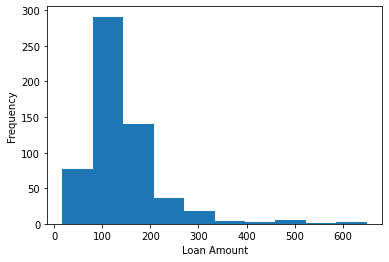

In [640]:
# Distribution of 'loan_amount'

print(train['loan_amount'].min())
print(train['loan_amount'].unique())

train['loan_amount'].plot(kind='hist')

plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show();

360.0    0.861592
180.0    0.067474
480.0    0.024221
300.0    0.020761
84.0     0.006920
120.0    0.005190
240.0    0.005190
60.0     0.003460
36.0     0.003460
12.0     0.001730
Name: loan_amount_term, dtype: float64 



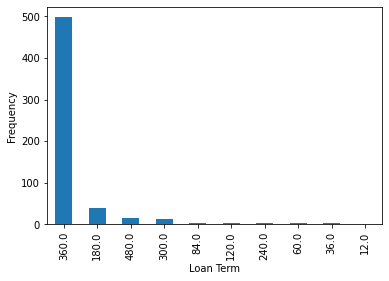

In [641]:
# Most applicants apper to be applying for loans with 30-year term lengths

print(train['loan_amount_term'].value_counts(normalize=True), "\n")

train['loan_amount_term'].value_counts().plot(kind='bar')
plt.xlabel('Loan Term')
plt.ylabel('Frequency')
plt.show()

1    0.856401
0    0.143599
Name: credit_history, dtype: float64 

object


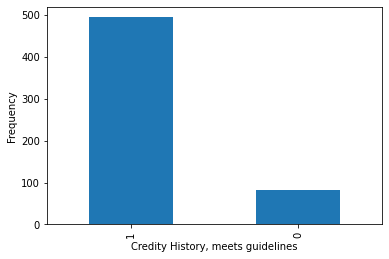

In [642]:
# Most applicants 'credit_history' meet guidelines

print(train['credit_history'].value_counts(normalize=True), "\n")
print(train['credit_history'].dtypes)

train['credit_history'].value_counts().plot(kind='bar')
plt.xlabel('Credity History, meets guidelines')
plt.ylabel('Frequency')
plt.show()

Semiurban    0.385813
Urban        0.321799
Rural        0.292388
Name: property_area, dtype: float64 

object


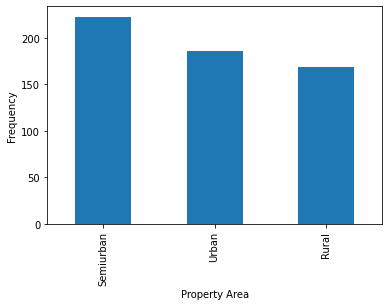

In [643]:
# Most 'property_area'

print(train['property_area'].value_counts(normalize=True), "\n")
print(train['property_area'].dtypes)

train['property_area'].value_counts().plot(kind='bar')
plt.xlabel('Property Area')
plt.ylabel('Frequency')
plt.show()

In [644]:
train.shape
train.head()

,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
1,Male,Yes,1,Graduate,No,4583,1508,128,360.0,1,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0,66,360.0,1,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358,120,360.0,1,Urban,1
4,Male,No,0,Graduate,No,6000,0,141,360.0,1,Urban,1
5,Male,Yes,2,Graduate,Yes,5417,4196,267,360.0,1,Urban,1


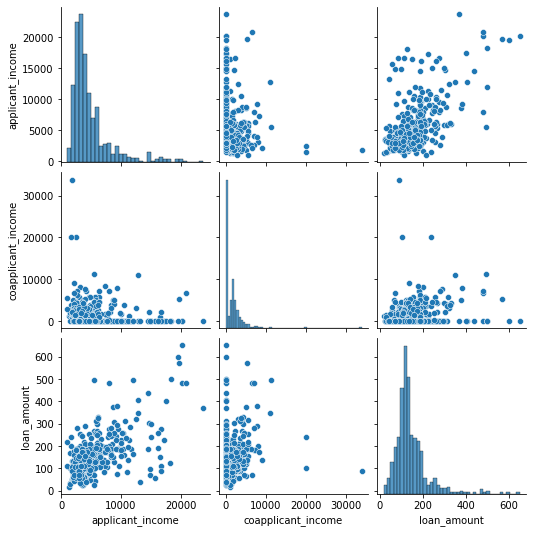

In [645]:
# Examine for correlation among continuous variables

sns.pairplot(train[['applicant_income', 'coapplicant_income', 'loan_amount']])

In [646]:
# Create Feature Matrix and Target Array

target = 'loan_status'

y = train[target]
X = train.drop(columns=target)

In [647]:
y.shape

(578,)

In [648]:
# Split the data
# Will use a random split; there is no datetime information included in this dataset.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish a Baseline

In [649]:
# Establish a baseline for this classification problem - 'Was the loan approved?'
# The classes of the Target Vector are moderately imbalanced towards approval
# Since this is a classification problem we will be looking at accuracy 
# You have a 69.15% chance of being correct if you always decide that the loan was approved; this is our baseline
# to beat

print(y_train.value_counts(normalize=True), "\n")
print('Baseline Accuracy: {:.4f}'.format(y_train.value_counts(normalize=True).max()))

1    0.688312
0    0.311688
Name: loan_status, dtype: float64 

Baseline Accuracy: 0.6883


In [650]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462 entries, 265 to 110
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gender              452 non-null    object
 1   married             460 non-null    object
 2   dependents          462 non-null    object
 3   education           462 non-null    object
 4   self_employed       440 non-null    object
 5   applicant_income    462 non-null    int64 
 6   coapplicant_income  462 non-null    int64 
 7   loan_amount         462 non-null    int64 
 8   loan_amount_term    462 non-null    object
 9   credit_history      462 non-null    object
 10  property_area       462 non-null    object
dtypes: int64(3), object(8)
memory usage: 43.3+ KB


# IV. Build Models

- `LogisticRegression`
    
    - `OneHotEncoder`
    - `SimpleImputer`
    - `StandardScaler`
 
- `RandomForrestClassifier`

    - `OrdinalEncoder`
    - `SimpleImputer`

In [654]:
# Model 1: Logistic Regression Model

model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender', 'married', 'dependents',
                                     'education', 'self_employed',
                                     'loan_amount_term', 'credit_history',
                                     'property_area'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [655]:
# Model 1: Random Forest Classifier Model

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(st
                  rategy='most_frequent'),
    StandardScaler(),
    RandomForestClassifier(n_jobs=-1, random_state=42)
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'married', 'dependents',
                                      'education', 'self_employed',
                                      'loan_amount_term', 'credit_history',
                                      'property_area'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN       3
dtype: int64},
                                         {'col': 'married',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
Yes    2
NaN    3
dtype: int64},
                                         {'col': 'dependents',
                                          '...
                                         {'col': 'credit_history',
                                          'data_type': dtype('O

In [683]:
# Model 2: XG-Boost Classifier

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    XGBClassifier(random_state=42, n_jobs=-1)
)

model_xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'married', 'dependents',
                                      'education', 'self_employed',
                                      'loan_amount_term', 'credit_history',
                                      'property_area'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN       3
dtype: int64},
                                         {'col': 'married',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
Yes    2
NaN    3
dtype: int64},
                                         {'col': 'dependents',
                                          '...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
    

# V. Check Metrics 

In [679]:
# Classification: Is your majority class frequency >= 50% and < 70% ? 
# If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. 
# What evaluation metric will you choose, in addition to or instead of accuracy?

# Our majority class is less than 70% and can just use accuracy.  Should, however, come back and build out a 
# confusion_matrix, and look at recall/precision.  Will also explore Precision, Recall, and F1 Score.

In [680]:
# Training and Validation accuracy of our Logistic Regression model

print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.8268398268398268
Validation Accuracy (LOGR): 0.8275862068965517


In [681]:
# Training and Validation accuracy of our Random Forest Classifier model

print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.7844827586206896


In [682]:
# Training and Validation accuracy of our XGBoost Classifier model
# Model appears to be overfit

print('Training Accuracy (XGB):', model_xgb.score(X_train, y_train))
print('Valdiation Accuracy (XGB):', model_xgb.score(X_val, y_val))

Training Accuracy (XGB): 1.0
Valdiation Accuracy (XGB): 0.7672413793103449


In [661]:
# LOGISTIC REGRESSION, preformance
# Not very good precision for Y, great recall for Y

print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))

Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.48      0.60        31
           1       0.84      0.95      0.89        85

    accuracy                           0.83       116
   macro avg       0.81      0.72      0.75       116
weighted avg       0.82      0.83      0.81       116



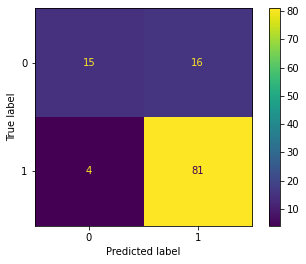

In [662]:
# LOGISTIC REGRESSION
# Plot Confusion Matrix

plot_confusion_matrix(model_lr, X_val, y_val, values_format='.0f')

# TN FP
#
# FN TP

In [663]:
# LOGISTIC REGRESSION
# Calculate Precision and Recall

# Precision = TP / (TP + FP)
precision = 81 / (81 + 16)

# Recall = TP / (TP + FN)
recall = 81 / (81 + 4)

print('Logistic Regression model precision', precision)
print('Logistic Regression model recall', recall)

Logistic Regression model precision 0.8350515463917526
Logistic Regression model recall 0.9529411764705882


In [664]:
# RANDOM FOREST CLASSIFIER, preformance
# My comments here ************************

print('Random Forest Classifier')
print(classification_report(y_val, model_rf.predict(X_val)))

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.64      0.45      0.53        31
           1       0.82      0.91      0.86        85

    accuracy                           0.78       116
   macro avg       0.73      0.68      0.69       116
weighted avg       0.77      0.78      0.77       116



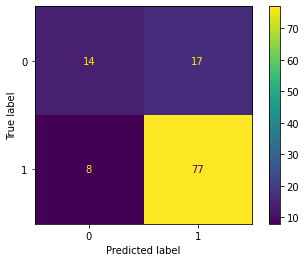

In [665]:
# RANDOM FOREST CLASSIFIER
# Plot Confusion Matrix

plot_confusion_matrix(model_rf, X_val, y_val, values_format='.0f') 

# TN FP
#
# FN TP

In [666]:
# RANDOM FOREST CLASSIFIER 
# Calculate Precision and Recall

# Precision = TP / (TP + FP)
precision = 77 / (77 + 17)

# Recall = TP / (TP + FN)
recall = 77 / (77 + 8)

print('Logistic Regression model precision', precision)
print('Logistic Regression model recall', recall)

Logistic Regression model precision 0.8191489361702128
Logistic Regression model recall 0.9058823529411765


In [667]:
# XGBoost CLASSIFIER, preformance
# My comments here**********

print('XGBoost Classifier')
print(classification_report(y_val, model_xgb.predict(X_val)))

XGBoost Classifier
              precision    recall  f1-score   support

           0       0.60      0.48      0.54        31
           1       0.82      0.88      0.85        85

    accuracy                           0.78       116
   macro avg       0.71      0.68      0.69       116
weighted avg       0.76      0.78      0.77       116



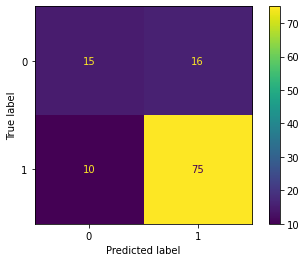

In [668]:
# XGBoost CLASSIFIER
# Plot Confusion Matrix

plot_confusion_matrix(model_xgb, X_val, y_val, values_format='.0f') 

# TN FP
#
# FN TP

In [669]:
# XGBoost CLASSIFIER 
# Calculate Precision and Recall

# Precision = TP / (TP + FP)
precision = 75 / (75 + 16)

# Recall = TP / (TP + FN)
recall = 75 / (75 + 10)

print('Logistic Regression model precision', precision)
print('Logistic Regression model recall', recall)

Logistic Regression model precision 0.8241758241758241
Logistic Regression model recall 0.8823529411764706


## ROC Curve

- To evalute models for binary classification
- To decide what probability threshold you should use when making your predictions

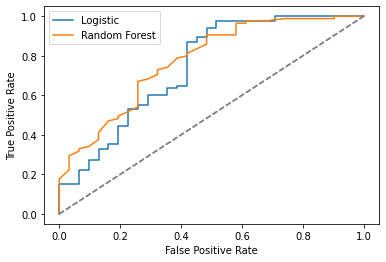

In [670]:
# Use VALIDATION DATA

# ROC curve is used with classification problems
# 'How far up can I go without having to go too far to the right?'
# An ROC curve let's you see how your model will perform at various thresholds
# Also allows you to compare different models 

lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rd = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [671]:
print('Logistic: ROA-AUC Score:', roc_auc_score(y_val, model_lr.predict(X_val)))
print('Random Forest: ROC-AUC Score:', roc_auc_score(y_val, model_rf.predict(X_val)))

Logistic: ROA-AUC Score: 0.7184060721062618
Random Forest: ROC-AUC Score: 0.6787476280834914


In [677]:
# Logisitic Regression coefficients

coefs = model_lr.named_steps['logisticregression'].coef_[0]
model_lr.named_steps['onehotencoder'].get_feature_names()

['gender_Male',
 'gender_Female',
 'gender_nan',
 'married_No',
 'married_Yes',
 'married_nan',
 'dependents_0',
 'dependents_2',
 'dependents_1',
 'dependents_3',
 'education_Graduate',
 'education_Not Graduate',
 'self_employed_No',
 'self_employed_Yes',
 'self_employed_nan',
 'applicant_income',
 'coapplicant_income',
 'loan_amount',
 'loan_amount_term_360.0',
 'loan_amount_term_480.0',
 'loan_amount_term_180.0',
 'loan_amount_term_240.0',
 'loan_amount_term_120.0',
 'loan_amount_term_84.0',
 'loan_amount_term_300.0',
 'loan_amount_term_36.0',
 'loan_amount_term_60.0',
 'loan_amount_term_12.0',
 'credit_history_1',
 'credit_history_0',
 'property_area_Rural',
 'property_area_Urban',
 'property_area_Semiurban']

In [ ]:
lr.fit(X_train, y_train)

coefs = lr.named_steps['logisticregression'].coef_[0]
features = lr.named_steps['onehotencoder'].get_feature_names()
pd.Series(coefs, index=features).sort_values(key=abs).tail(10).plot(kind='barh')